In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/ML WOC/Data Sets/multiclass/multi_classification_train.csv'
data = pd.read_csv(path)

In [ ]:
data = data.drop("ID", axis=1)
print(data.head())
data_np = data.to_numpy()
print(data_np.shape)
Y = data['Class']
X = data.drop('Class', axis=1)
X = X.to_numpy()
Y = Y.to_numpy()
print(f"The shape of X is {X.shape}")
print(f"The shape of y is {Y.shape}")
classes = np.unique(Y)
print(classes)

    Feature_1  Feature_2  Feature_3   Feature_4   Feature_5   Feature_6  \
0  -90.532634 -66.953472  79.261856 -111.800554  126.403549  111.509348   
1 -103.156720 -16.070400  87.819228   12.614599   51.347780   67.483725   
2   24.326153 -92.098078  82.238354  -56.795879   85.203996  127.916504   
3  -64.631737 -83.703583  84.135072   -5.516152   74.338494  112.630556   
4  -55.473830 -78.853237  88.129107   75.200543   76.991520   60.224711   

    Feature_7   Feature_8   Feature_9  Feature_10  ...  Feature_12  \
0  207.728953  -26.600556 -106.229324  170.384649  ...  148.391734   
1   40.269172   51.442254 -151.486693   35.872507  ...   29.009475   
2  -90.080307 -128.124071   18.036020   70.485076  ...  111.810098   
3  181.576798   -1.054023   60.469865   -0.658352  ...   50.047108   
4  -13.106559 -146.773016  -33.490566  137.684666  ...   85.988282   

   Feature_13  Feature_14  Feature_15  Feature_16  Feature_17  Feature_18  \
0   77.835738  -10.728207    1.100625    1.035362  

In [ ]:
X_mean = np.mean(X)
X_std = np.std(X)
X = (X-X_mean)/X_std
indxs = np.random.permutation(X.shape[0])
X = X[indxs]
Y = Y[indxs]
x_train = X[:42000]
y_train = Y[:42000]
x_test = X[42000:]
y_test = Y[42000:]

In [ ]:
class NeuralNetwork:
  def __init__(self, layer_list, act_funcs, alpha = 3e-2, batch_size=32, epochs=100):
    self.layer_list = layer_list
    self.alpha = alpha
    self.batch_size = batch_size
    self.epochs = epochs
    self.params = {}
    self.cache = {}
    self.grads = {}
    self.act_funcs = act_funcs
    self._init_params(log_it=True)

  #Useful funcs:
  def _relu(self, z):
    return np.maximum(z,0)
  def _softmax(self, z):
    A = np.exp(z)/sum(np.exp(z))
    return A
  def _sigmoid(self, z):
    return 1/(1+np.exp(-z))
  def _reluDer(self, z):
    return (z >0).astype(int)
  def _get_deltaZ_lastLayer(self,A, Y):
    return A - Y
  def _compute_cost(self,A, Y, cost_func):
    if 'soft' in cost_func:
        m = Y.shape[1]
        cost = -np.sum(Y * np.log(A)) / m
        return cost
    elif 'sigm' in cost_func:
        m = Y.shape[1]
        cost = (-1 / m) * np.sum(np.multiply(Y, np.log(A)) + np.multiply(1 - Y, np.log(1 - A)))
        return cost
    else:
        raise Exception("Unsupported Cost function")
  def _one_hot(self, Y):
    uniq_labels = np.unique(Y)
    C = len(uniq_labels)
    m = Y.size
    one_hot_Y = np.zeros((C, m))
    label_to_index = {label: index for index, label in enumerate(uniq_labels)}
    indices = [label_to_index[label] for label in Y]
    one_hot_Y[indices, np.arange(m)] = 1
    # for i in range(m):
    #   one_hot_Y[Y[i], i] = 1
    return one_hot_Y

    #params create:
  def _init_params(self,log_it=True):
    L = len(self.layer_list)
    for l in range(1,L):
      self.params[f"W{l}"] = np.random.randn(self.layer_list[l], self.layer_list[l-1]) * np.sqrt(2 / self.layer_list[l-1]) #He method
      self.params[f"b{l}"] = np.random.randn(self.layer_list[l], 1) * np.sqrt(2 / self.layer_list[l-1])
    print("Parameters initialized: ", {key: val.shape for key, val in self.params.items()}) if log_it else None
  def _fwd_prp(self, X):
    self.cache["A0"] = X
    L = len(self.layer_list) - 1
    for l in range(1, L+1):
      Z = np.dot(self.params[f"W{l}"], self.cache[f"A{l-1}"]) + self.params[f"b{l}"]
      self.cache[f"Z{l}"] = Z
      if "relu" in self.act_funcs[l-1]:
        self.cache[f"A{l}"] = self._relu(Z)
      elif 'sig' in self.act_funcs[l-1]:
        self.cache[f"A{l}"] = self._sigmoid(Z)
      elif 'soft' in self.act_funcs[l-1]:
        self.cache[f"A{l}"] = self._softmax(Z)
      else:
        raise Exception("Unsupported activation function")
    return self.cache[f"A{L}"]
  def _update_grads(self, X, Y):
    #No of layers
    L = len(self.layer_list) - 1
    m = Y.shape[1]
    A_last = self.cache[f"A{L}"]
    if self.act_funcs[L-1] == 'sigmoid' or "softmax":
      dZ = self._get_deltaZ_lastLayer(A_last, Y)
    self.grads[f"dZ{L}"] = dZ
    self.grads[f"dW{L}"] = np.dot(dZ, self.cache[f"A{L-1}"].T) / m
    self.grads[f"db{L}"] = np.sum(dZ, axis = 1, keepdims = True)

    for l in reversed(range(1,L)):
      dA = np.dot(self.params[f"W{l+1}"].T, dZ) #this is the dA of the current layer
      Z = self.cache[f"Z{l}"]
      A = self.cache[f"A{l}"]
      activation = self.act_funcs[l-1] #when l = 1, it is the first hidden layer, correspondingly , activations[0] gives the act func of that layer
      if activation == "relu":
        dZ = dA * self._reluDer(Z)
      elif activation == "sigmoid":
        dZ = dA * (A * (1 - A))
      else:
        raise ValueError(f"Unsupported activation function: {activation}")

      self.grads[f"dZ{l}"] = dZ
      self.grads[f"dW{l}"] = (1/m)*np.dot(dZ, self.cache[f"A{l-1}"].T)
      self.grads[f"db{l}"] = (1/m)*np.sum(dZ, axis = 1, keepdims = True)

    # return self.grads
  def _update_params(self):
      L = len(self.layer_list) - 1
      for l in range(1, L + 1):
          self.params[f"W{l}"] -= self.alpha*self.grads[f"dW{l}"]
          self.params[f"b{l}"] -= self.alpha*self.grads[f"db{l}"]


  def train(self, X, Y, cost_func = 'soft',details=True,plot_costs=True):
    m = X.shape[1]
    if 'sigm' in self.act_funcs[-1]:
      Y = Y.reshape(1,m)
    else:
      Y = self._one_hot(Y)
    J_history_batches = []
    J_history_entire = []
    for epoch in range(1, self.epochs+1):
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[:, permutation]

        batches = m // self.batch_size
        for k in range(0, batches):
            mini_batch_X = X_shuffled[:, k*self.batch_size:(k+1)*self.batch_size]
            mini_batch_Y = Y_shuffled[:, k*self.batch_size:(k+1)*self.batch_size]

            A_last = self._fwd_prp(mini_batch_X)
            self._update_grads(mini_batch_X, mini_batch_Y)
            self._update_params()
            cost = self._compute_cost(A_last, mini_batch_Y, cost_func)
            J_history_batches.append(cost)
            if details:
                print(f"Epoch: {epoch:03d}, Batch: {k+1}/{batches}, Cost: {cost:.6f}")
        if m % batches != 0:
            mini_batch_X = X_shuffled[:, batches*self.batch_size:m]
            mini_batch_Y = Y_shuffled[:, batches*self.batch_size:m]

            A_last = self._fwd_prp(mini_batch_X)
            self._update_grads(mini_batch_X, mini_batch_Y)
            self._update_params()
            cost = self._compute_cost(A_last, mini_batch_Y, cost_func)
            J_history_batches.append(cost)
            if details:
                print(f"Epoch: {epoch:03d}, Batch: last, Cost: {cost:.6f}")
        A_last = self._fwd_prp(X_shuffled)
        cost = self._compute_cost(A_last, Y_shuffled, cost_func)
        J_history_entire.append(cost)

        if 'sigm' in self.act_funcs[-1]:
          predictions = self.predict_bin(X_shuffled)
        else:
          predictions = self.predict(X_shuffled)
        true_Y = np.argmax(Y_shuffled, axis=0)
        accuracy = self.get_accuracy(predictions, true_Y)
        print(f"Epoch: {epoch:03d}, Cost: {cost:.6f}, accuracy: {accuracy:.4f}")
    self._plotter(J_history_entire) if plot_costs else None
    return J_history_batches, J_history_entire


  def predict(self, X):
      A_last = self._fwd_prp(X)
      predictions = np.argmax(A_last, axis = 0)
      return predictions
  def get_accuracy(self, predictions, Y):
      accuracy = 100* np.mean(predictions == Y)
      return accuracy

  def k_fold_cv(self, X, Y, k_folds, cost_func, details=True,plot_acc=True,plot_cost_vs_epoch=True,retrain=True):
    m = X.shape[1]
    indices = np.random.permutation(m)
    X_shuffled = X[:, indices]
    if plot_cost_vs_epoch:
      J_hist_list = []
    # Y = self._one_hot(Y) dont use one hot here, as the train function takes the 1d Y and does the one hot there only
    Y_shuffled = Y[indices]
    fold_size = m//k_folds
    training_accuracies = []
    testing_accuracies = []
    for fold in range(k_folds):
      print(f"Working on fold {fold+1}.....")
      test_start = fold*fold_size
      test_end = (fold+1)*fold_size if fold < k_folds - 1 else m
      self._init_params(log_it=False)
      X_train = np.concatenate((X_shuffled[:, :test_start], X_shuffled[:, test_end:]), axis = 1)
      Y_train = np.concatenate((Y_shuffled[:test_start], Y_shuffled[test_end:]))
      X_test = X_shuffled[:,test_start:test_end]
      Y_test = Y_shuffled[test_start:test_end]
      useless,J_hist = self.train(X_train, Y_train, cost_func, details,plot_costs=False)
      if plot_cost_vs_epoch:
        J_hist_list.append(J_hist)
      training_predictions = self.predict_bin(X_train) if 'sigm' in self.act_funcs[-1] else self.predict(X_train)
      testing_predictions = self.predict_bin(X_test) if 'sigm' in self.act_funcs[-1] else self.predict(X_test)
      # training_predictions = self.predict(X_train)
      # testing_predictions = self.predict(X_test)
      training_accuracy = self.get_accuracy(training_predictions, Y_train)
      print(f"The training accuracy for fold: {fold+1} is {training_accuracy:.4f}")
      testing_accuracy = self.get_accuracy(testing_predictions, Y_test)
      print(f"The testing accuracy for fold: {fold+1} is {testing_accuracy:.4f}")
      training_accuracies.append(training_accuracy)
      testing_accuracies.append(testing_accuracy)
      print(f"Fold {fold+1} Completed!")
      print(f"Starting fold {fold+2}") if fold < k_folds - 1 else None
    mean_of_training_accuracies = np.mean(training_accuracies)
    mean_of_testing_accuracies = np.mean(testing_accuracies)
    print(f"Mean of training accuracies: {mean_of_training_accuracies:.4f}")
    print(f"Mean of testing accuracies: {mean_of_testing_accuracies:.4f}")
    if plot_cost_vs_epoch:
      for fold in range(k_folds):
            plt.plot(np.arange(1,len(J_hist_list[fold])+1), J_hist_list[fold], c='r')
            plt.xlabel('Epochs')
            plt.ylabel('Cost')
            plt.title(f"Cost vs Epochs for fold {fold+1}")
            plt.show()
    if retrain:
      print("Retraining the model on the entire dataset....")
      self._init_params(log_it=True)
      self.train(X, Y, cost_func, details,plot_costs=False)
      print("Retraining complete.")


    self._plotter_for_CV(training_accuracies,testing_accuracies) if plot_acc else None

    return training_accuracies, testing_accuracies, mean_of_training_accuracies, mean_of_testing_accuracies


  def _plotter(self, J_history):
    plt.plot(np.arange(1,len(J_history)+1), J_history, c='r')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title("Cost vs Epochs")
    plt.show()

  def _plotter_for_CV(self, training_accuracies, testing_accuracies):
    k_folds = len(training_accuracies)
    plt.plot(np.arange(1,k_folds+1), training_accuracies, c='green',label='Training Accuracy')
    plt.plot(np.arange(1,k_folds+1), testing_accuracies, c='blue',label='Testing Accuracy')
    plt.xlabel("Folds")
    plt.ylabel("Accuracies")
    plt.title("Folds vs Accuracies")
    plt.legend()
    plt.show()
  def predict_bin(self,X):
      A_last = self._fwd_prp(X)
      # predictions = np.zeros((X.shape[0],))
      # for i in range(len(X.shape[0])):
      #   predictions[i] = 1 if A_last[i] > 0.5 else 0
      predictions = (A_last > 0.5).astype(int)
      return predictions

  def get_conf_mat(self, Y_act, Y_pred):
    n_cls = len(np.unique(Y_act))
    con_mat = np.zeros((n_cls, n_cls))
    for indx, label in enumerate(Y_act):
      con_mat[label, Y_pred[indx]] += 1

    return con_mat

  def print_con_mat(self, con_mat):
    print("Confusion matrix with predictions on X axis and actual values on Y")
    classes= np.arange(con_mat.shape[0])
    table = pd.DataFrame(con_mat, index=classes, columns=classes)
    print(table)

  def get_precision(self,con_mat):
    precs = np.zeros((con_mat.shape[0],))
    for i in range(con_mat.shape[0]):
      precs[i] = con_mat[i,i]/np.sum(con_mat[:,i])

    return precs

  def get_recall(self, con_mat):
    recs = np.zeros((con_mat.shape[0],))
    for i in range(con_mat.shape[0]):
      recs[i] = con_mat[i,i]/np.sum(con_mat[i,:])

    return recs

  def get_f1s(self, con_mat):
    precs = self.get_precision(con_mat)
    recs = self.get_recall(con_mat)
    f1s = 2*recs*precs/(recs + precs)
    return f1s

  def classification_report(self, Y_act, Y_pred):
    con_mat = self.get_conf_mat(Y_act, Y_pred)
    precs = self.get_precision(con_mat)
    recs = self.get_recall(con_mat)
    f1s = self.get_f1s(con_mat)
    supports = con_mat.sum(axis=1)
    classes= np.arange(con_mat.shape[0])
    reports = []
    for i in range(con_mat.shape[0]):
      reports.append([precs[i], recs[i], f1s[i], supports[i]])
    table1 = pd.DataFrame(reports,index=classes, columns=['precision','recall','f1-score','support'])
    # print(table1)
    wted_prec = np.average(precs, weights=supports)
    wted_rec = np.average(recs, weights=supports)
    wted_f1 = np.average(f1s, weights=supports)
    tot_support = np.sum(supports)
    wted_data = [[wted_prec,wted_rec,wted_f1,tot_support]]
    table2 = pd.DataFrame(wted_data,index=['Average (weighted)'],columns=['precision', 'recall', 'f1-score', 'support'])
    # print('\n\n', table2)
    table = pd.concat([table1, table2])
    print(table)
    print(f"Accuracy: {self.get_accuracy(Y_pred, Y_act)}%")


In [ ]:
layer_list = [20, 16,16,5]
act_funcs = ['relu','relu','softmax']
model = NeuralNetwork(layer_list, act_funcs,alpha=3e-2,epochs=300)

Parameters initialized:  {'W1': (16, 20), 'b1': (16, 1), 'W2': (16, 16), 'b2': (16, 1), 'W3': (5, 16), 'b3': (5, 1)}


In [ ]:
J_history_batches, J_history_entire = model.train(x_train.T, y_train, cost_func = 'soft',details=False,plot_costs=True)

Epoch: 001, Cost: 0.781715, accuracy: 72.7595
Epoch: 002, Cost: 0.613210, accuracy: 79.1119
Epoch: 003, Cost: 0.544485, accuracy: 81.7119


KeyboardInterrupt: 

In [ ]:
accuracy_train = model.get_accuracy(model.predict(x_train.T), y_train)
print(f"The accuracy Training (seen data) of the model is {accuracy_train:.4f}")
accuracy_test = model.get_accuracy(model.predict(x_test.T), y_test)
print(f"The accuracy Testing (unseen data) of the model is {accuracy_test:.4f}")

The accuracy Training (seen data) of the model is 95.1929
The accuracy Testing (unseen data) of the model is 95.0833


Working on fold 1.....
Epoch: 001, Cost: 0.411331, accuracy: 87.9688
Epoch: 002, Cost: 0.349329, accuracy: 90.7344
Epoch: 003, Cost: 0.327745, accuracy: 91.5729
Epoch: 004, Cost: 0.311890, accuracy: 91.9922
Epoch: 005, Cost: 0.305562, accuracy: 92.5026
Epoch: 006, Cost: 0.285004, accuracy: 93.2526
Epoch: 007, Cost: 0.292150, accuracy: 93.1042
Epoch: 008, Cost: 0.277214, accuracy: 93.5859
Epoch: 009, Cost: 0.271475, accuracy: 93.8281
Epoch: 010, Cost: 0.268141, accuracy: 93.8880
Epoch: 011, Cost: 0.260360, accuracy: 94.0885
Epoch: 012, Cost: 0.267264, accuracy: 93.8333
Epoch: 013, Cost: 0.257408, accuracy: 94.3385
Epoch: 014, Cost: 0.259933, accuracy: 94.3047
Epoch: 015, Cost: 0.253228, accuracy: 94.3698
Epoch: 016, Cost: 0.251630, accuracy: 94.3646
Epoch: 017, Cost: 0.254220, accuracy: 94.3047
Epoch: 018, Cost: 0.250527, accuracy: 94.4479
Epoch: 019, Cost: 0.247484, accuracy: 94.5208
Epoch: 020, Cost: 0.248468, accuracy: 94.6276
Epoch: 021, Cost: 0.240345, accuracy: 94.8828
Epoch: 022,

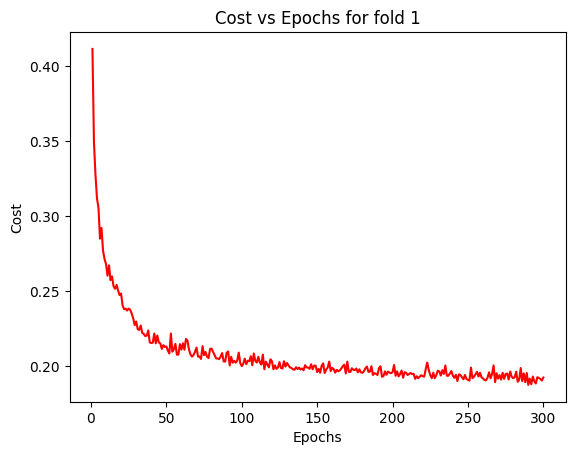

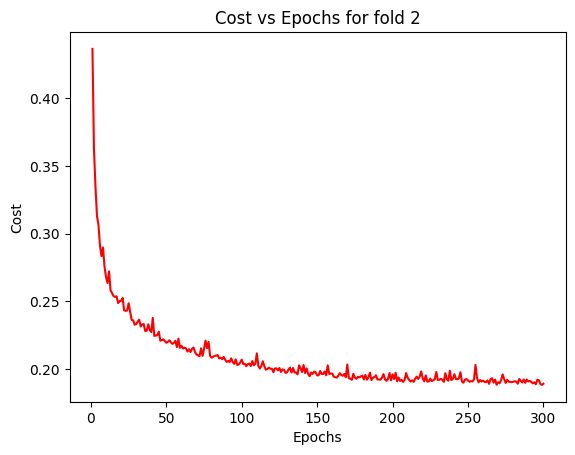

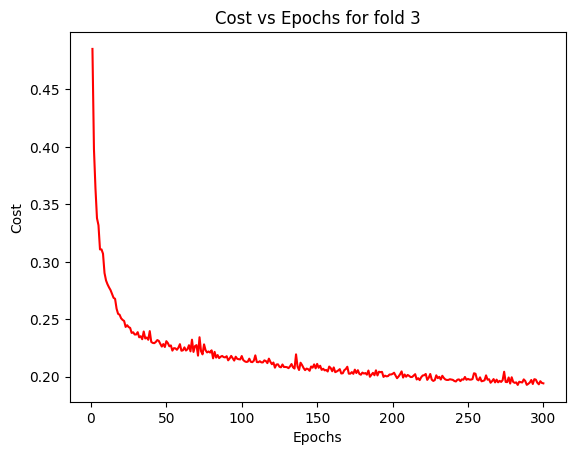

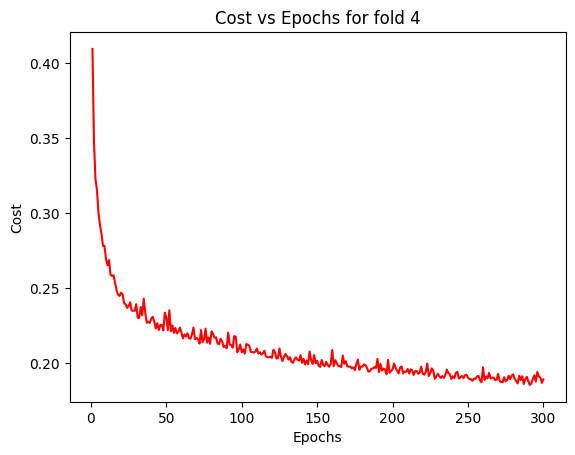

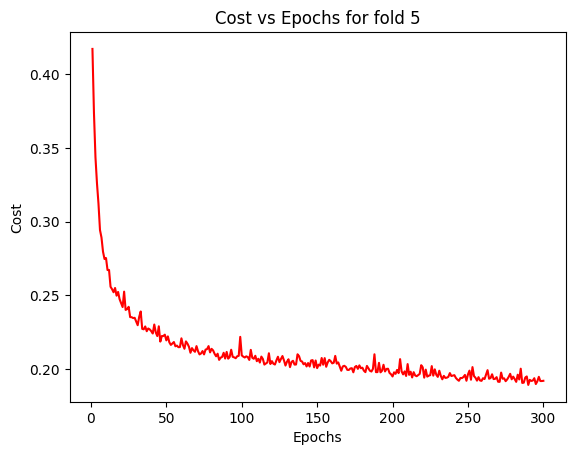

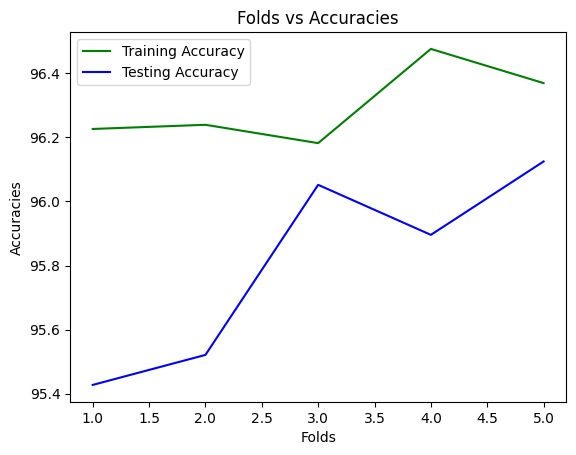

Training Report: 
                    precision    recall  f1-score  support
0                    0.937881  0.909628  0.923539   3552.0
1                    0.967257  0.975118  0.971172   9967.0
2                    0.967324  0.984273  0.975725  14497.0
3                    0.960931  0.957018  0.958971   8841.0
4                    0.964250  0.928252  0.945908   5143.0
Average (weighted)   0.963096  0.963190  0.963053  42000.0
Accuracy: 96.31904761904761%
Testing Report: 
                    precision    recall  f1-score  support
0                    0.910603  0.897541  0.904025    488.0
1                    0.966300  0.977731  0.971982   1437.0
2                    0.970191  0.982084  0.976101   2121.0
3                    0.962140  0.955846  0.958983   1223.0
4                    0.974395  0.937073  0.955370    731.0
Average (weighted)   0.963284  0.963333  0.963237   6000.0
Accuracy: 96.33333333333334%


In [ ]:
training_accuracies, testing_accuracies, mean_of_training_accuracies, mean_of_testing_accuracies = model.k_fold_cv(X.T, Y, k_folds=5, cost_func='soft',details=False,plot_acc=True,plot_cost_vs_epoch=True,retrain=False)
print("Training Report: ")
model.classification_report(y_train, model.predict(x_train.T))
print("Testing Report: ")
model.classification_report(y_test, model.predict(x_test.T))

In [ ]:
layers2 = [20, 16,16,5]
act_funcs2 = ['relu','relu','softmax']
model2 = NeuralNetwork(layers2, act_funcs2,alpha=3e-2,epochs=500)

Parameters initialized:  {'W1': (16, 20), 'b1': (16, 1), 'W2': (16, 16), 'b2': (16, 1), 'W3': (5, 16), 'b3': (5, 1)}


Working on fold 1.....
Epoch: 001, Cost: 0.351849, accuracy: 90.3958
Epoch: 002, Cost: 0.299521, accuracy: 92.4505
Epoch: 003, Cost: 0.278382, accuracy: 93.1615
Epoch: 004, Cost: 0.301970, accuracy: 92.5052
Epoch: 005, Cost: 0.260972, accuracy: 93.8151
Epoch: 006, Cost: 0.265186, accuracy: 93.7682
Epoch: 007, Cost: 0.252469, accuracy: 94.2630
Epoch: 008, Cost: 0.246815, accuracy: 94.3542
Epoch: 009, Cost: 0.245209, accuracy: 94.5339
Epoch: 010, Cost: 0.241165, accuracy: 94.5000
Epoch: 011, Cost: 0.237918, accuracy: 94.6380
Epoch: 012, Cost: 0.232895, accuracy: 94.9010
Epoch: 013, Cost: 0.231236, accuracy: 94.9089
Epoch: 014, Cost: 0.231822, accuracy: 94.8958
Epoch: 015, Cost: 0.232602, accuracy: 94.9115
Epoch: 016, Cost: 0.240019, accuracy: 94.6953
Epoch: 017, Cost: 0.247158, accuracy: 94.2839
Epoch: 018, Cost: 0.236834, accuracy: 94.6354
Epoch: 019, Cost: 0.235791, accuracy: 94.5182
Epoch: 020, Cost: 0.232480, accuracy: 94.9219
Epoch: 021, Cost: 0.230976, accuracy: 94.8125
Epoch: 022,

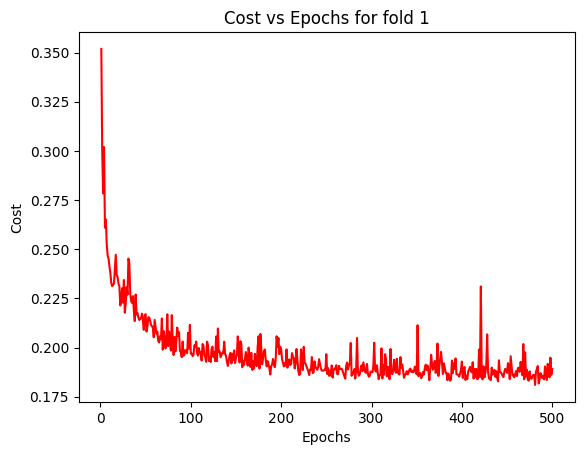

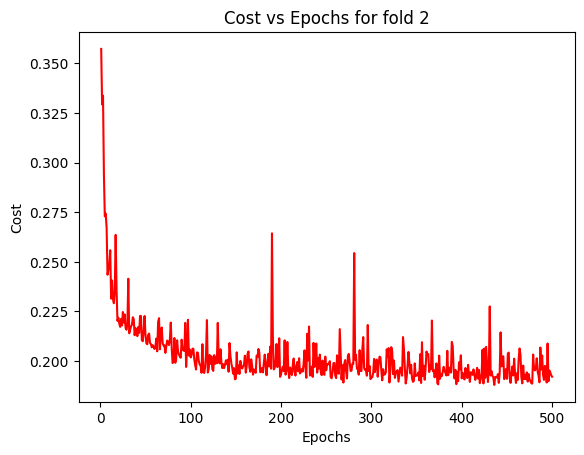

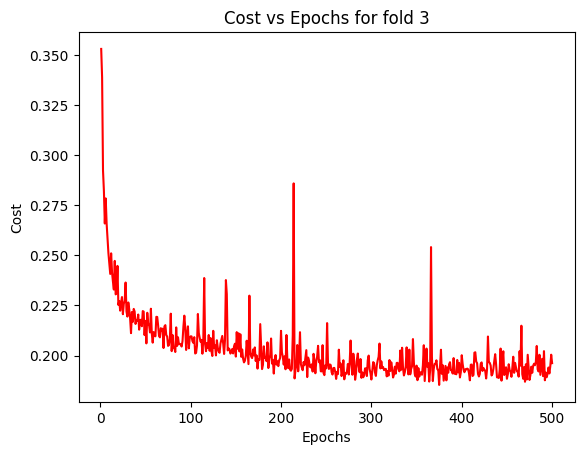

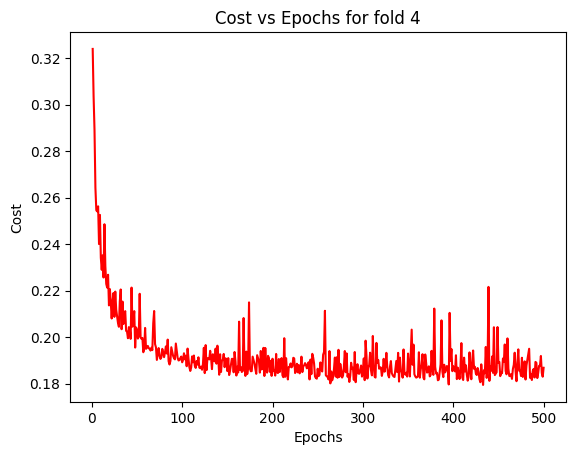

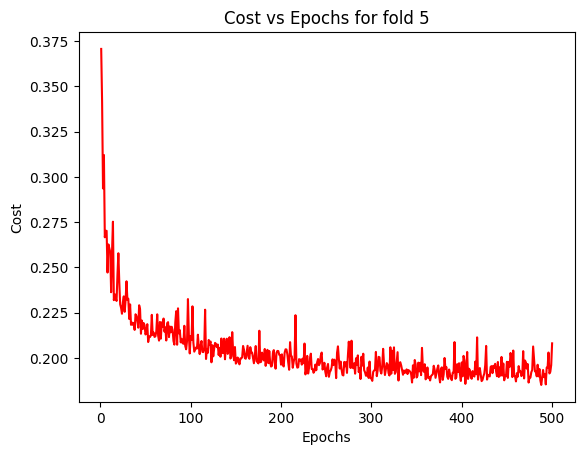

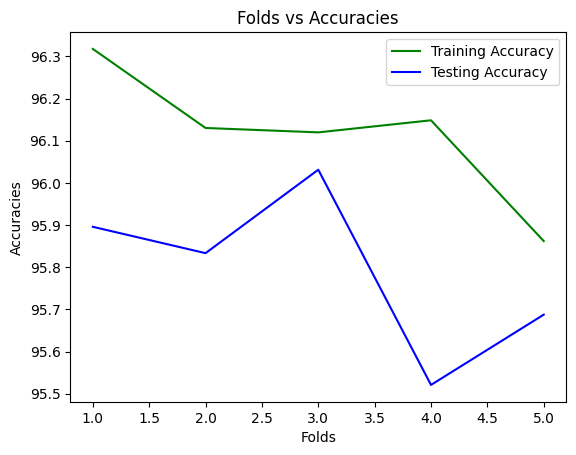

In [ ]:
training_accuracies2, testing_accuracies2, mean_of_training_accuracies2, mean_of_testing_accuracies2 = model2.k_fold_cv(X.T, Y, k_folds=5, cost_func='soft',details=False,plot_acc=True,plot_cost_vs_epoch=True,retrain=False)

Retraining on x_train: 
Epoch: 001, Cost: 0.196563, accuracy: 96.1214
Epoch: 002, Cost: 0.189697, accuracy: 96.3095
Epoch: 003, Cost: 0.190094, accuracy: 96.3214
Epoch: 004, Cost: 0.194509, accuracy: 96.2357
Epoch: 005, Cost: 0.196294, accuracy: 96.0857
Epoch: 006, Cost: 0.196728, accuracy: 96.1548
Epoch: 007, Cost: 0.194499, accuracy: 96.2619
Epoch: 008, Cost: 0.194059, accuracy: 96.2024
Epoch: 009, Cost: 0.192577, accuracy: 96.1976
Epoch: 010, Cost: 0.201519, accuracy: 95.7548
Epoch: 011, Cost: 0.188814, accuracy: 96.3381
Epoch: 012, Cost: 0.196393, accuracy: 96.2357
Epoch: 013, Cost: 0.205052, accuracy: 95.9095
Epoch: 014, Cost: 0.187747, accuracy: 96.4119
Epoch: 015, Cost: 0.233929, accuracy: 95.4786
Epoch: 016, Cost: 0.188881, accuracy: 96.3333
Epoch: 017, Cost: 0.191535, accuracy: 96.2643
Epoch: 018, Cost: 0.186766, accuracy: 96.3857
Epoch: 019, Cost: 0.188726, accuracy: 96.3952
Epoch: 020, Cost: 0.197369, accuracy: 96.1214
Epoch: 021, Cost: 0.191571, accuracy: 96.2690
Epoch: 022

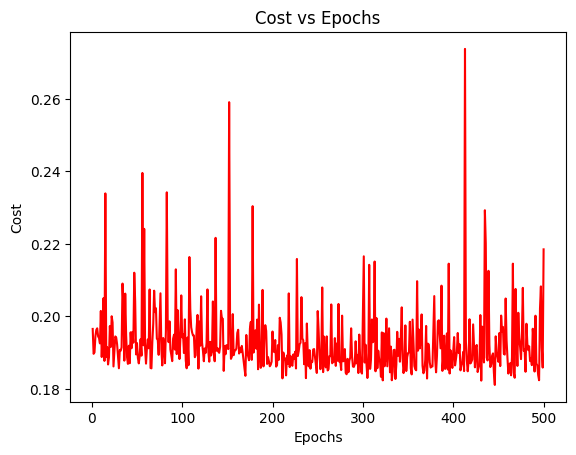

Retraining done! 
Classification report on training data: 
                    precision    recall  f1-score  support
0                    0.903547  0.877563  0.890365   3512.0
1                    0.952051  0.977932  0.964818   9969.0
2                    0.958731  0.985110  0.971742  14574.0
3                    0.961648  0.921611  0.941204   8815.0
4                    0.964474  0.926121  0.944909   5130.0
Average (weighted)   0.953845  0.953881  0.953607  42000.0
Accuracy: 95.38809523809523%
Classification report on testing data: 
                    precision    recall  f1-score  support
0                    0.931677  0.852273  0.890208    528.0
1                    0.951220  0.978397  0.964617   1435.0
2                    0.950611  0.988748  0.969305   2044.0
3                    0.967227  0.921537  0.943829   1249.0
4                    0.954483  0.930108  0.942138    744.0
Average (weighted)   0.953029  0.953000  0.952551   6000.0
Accuracy: 95.3%


In [ ]:
print("Retraining on x_train: ")
J_history_batches2, J_history_entire2 = model2.train(x_train.T, y_train, cost_func = 'soft',details=False,plot_costs=True)
print("Retraining done! ")
print("Classification report on training data: ")
model2.classification_report(y_train, model2.predict(x_train.T))
print("Classification report on testing data: ")
model2.classification_report(y_test, model2.predict(x_test.T))

In [ ]:
layers3 = [20, 32,32,5]
act_funcs3 = ['relu','relu','softmax']
model3 = NeuralNetwork(layers3, act_funcs3,alpha=3e-2,epochs=1000)

Parameters initialized:  {'W1': (32, 20), 'b1': (32, 1), 'W2': (32, 32), 'b2': (32, 1), 'W3': (5, 32), 'b3': (5, 1)}


Working on fold 1.....
Epoch: 001, Cost: 0.367029, accuracy: 89.6224
Epoch: 002, Cost: 0.312455, accuracy: 92.1979
Epoch: 003, Cost: 0.304549, accuracy: 92.4115
Epoch: 004, Cost: 0.267469, accuracy: 93.8411
Epoch: 005, Cost: 0.263982, accuracy: 93.8568
Epoch: 006, Cost: 0.252596, accuracy: 94.1771
Epoch: 007, Cost: 0.263043, accuracy: 93.5703
Epoch: 008, Cost: 0.251127, accuracy: 94.2135
Epoch: 009, Cost: 0.241038, accuracy: 94.6901
Epoch: 010, Cost: 0.236402, accuracy: 94.7500
Epoch: 011, Cost: 0.236971, accuracy: 94.7552
Epoch: 012, Cost: 0.240845, accuracy: 94.6380
Epoch: 013, Cost: 0.249573, accuracy: 94.3880
Epoch: 014, Cost: 0.237578, accuracy: 94.7474
Epoch: 015, Cost: 0.228345, accuracy: 95.0781
Epoch: 016, Cost: 0.227559, accuracy: 95.1380
Epoch: 017, Cost: 0.250574, accuracy: 94.1927
Epoch: 018, Cost: 0.232089, accuracy: 94.9219
Epoch: 019, Cost: 0.223132, accuracy: 95.2266
Epoch: 020, Cost: 0.227438, accuracy: 95.1354
Epoch: 021, Cost: 0.226282, accuracy: 95.0677
Epoch: 022,

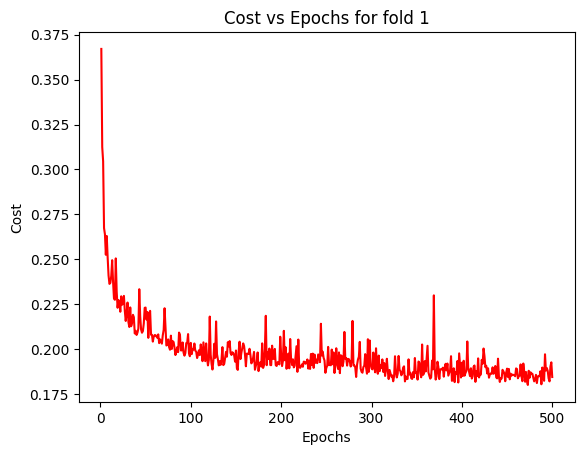

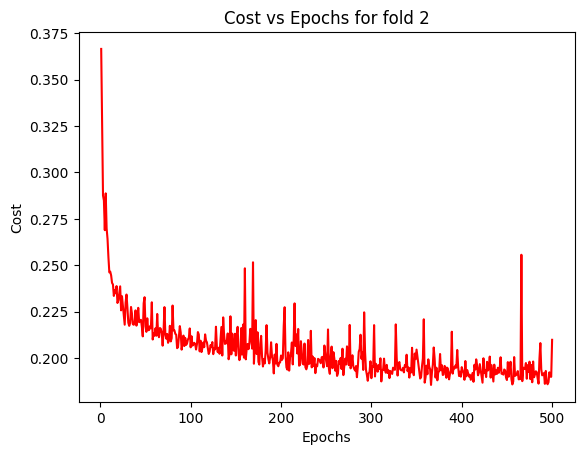

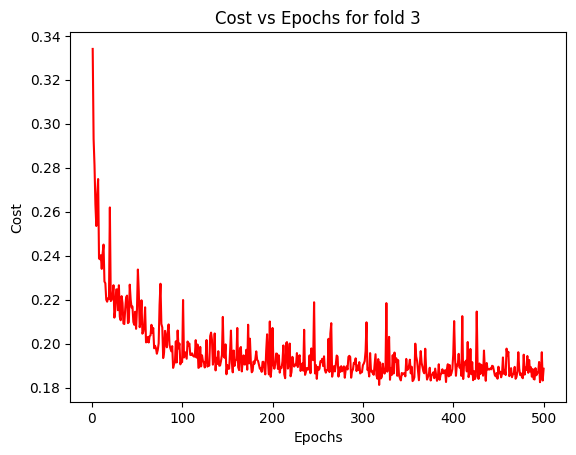

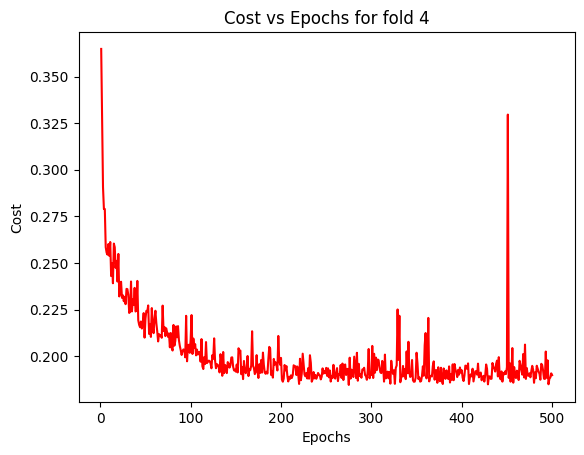

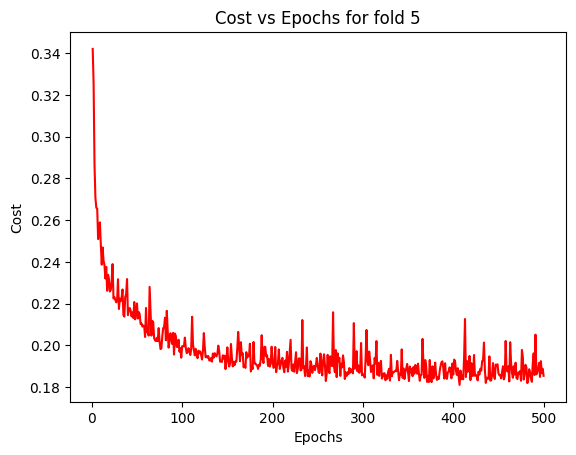

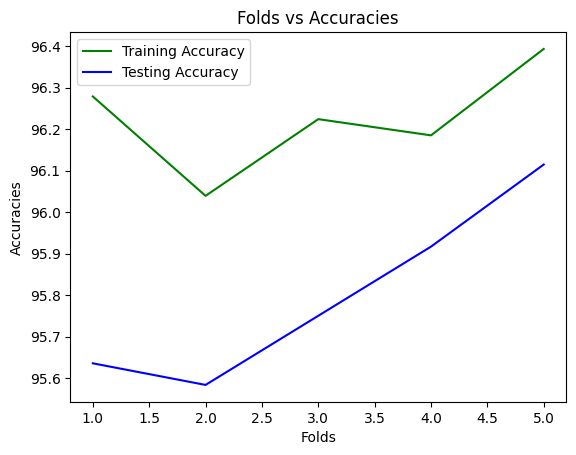

Epoch: 001, Cost: 0.383708, accuracy: 89.2833
Epoch: 002, Cost: 0.310712, accuracy: 92.3095
Epoch: 003, Cost: 0.294753, accuracy: 92.8952
Epoch: 004, Cost: 0.275657, accuracy: 93.5905
Epoch: 005, Cost: 0.269327, accuracy: 93.9310
Epoch: 006, Cost: 0.258003, accuracy: 94.3667
Epoch: 007, Cost: 0.250757, accuracy: 94.5690
Epoch: 008, Cost: 0.247106, accuracy: 94.6071
Epoch: 009, Cost: 0.245781, accuracy: 94.6476
Epoch: 010, Cost: 0.240999, accuracy: 95.0571
Epoch: 011, Cost: 0.230934, accuracy: 95.2071
Epoch: 012, Cost: 0.236173, accuracy: 95.1619
Epoch: 013, Cost: 0.227214, accuracy: 95.3214
Epoch: 014, Cost: 0.225143, accuracy: 95.4095
Epoch: 015, Cost: 0.224235, accuracy: 95.4524
Epoch: 016, Cost: 0.219824, accuracy: 95.5286
Epoch: 017, Cost: 0.217709, accuracy: 95.6762
Epoch: 018, Cost: 0.219028, accuracy: 95.5952
Epoch: 019, Cost: 0.212631, accuracy: 95.7810
Epoch: 020, Cost: 0.208320, accuracy: 95.9595
Epoch: 021, Cost: 0.210118, accuracy: 95.8190
Epoch: 022, Cost: 0.207176, accura

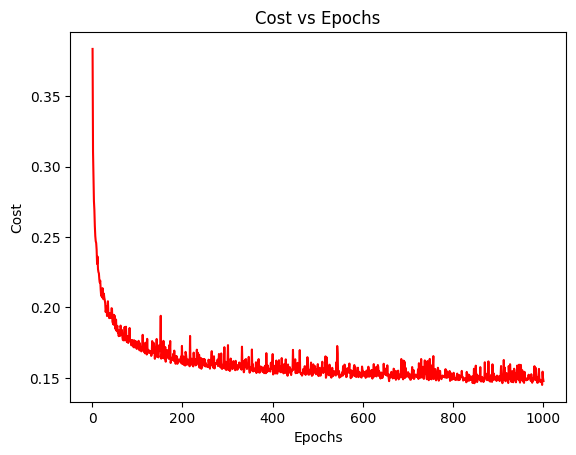

Classification report on training data: 
                    precision    recall  f1-score  support
0                    0.968164  0.926538  0.946894   3512.0
1                    0.974480  0.976728  0.975602   9969.0
2                    0.972121  0.985728  0.978877  14574.0
3                    0.968205  0.970732  0.969467   8815.0
4                    0.967402  0.948733  0.957977   5130.0
Average (weighted)   0.970952  0.970976  0.970898  42000.0
Accuracy: 97.09761904761905%
Classification report on testing data: 
                    precision    recall  f1-score  support
0                    0.963340  0.895833  0.928361    528.0
1                    0.973611  0.977003  0.975304   1435.0
2                    0.968269  0.985323  0.976722   2044.0
3                    0.963913  0.962370  0.963141   1249.0
4                    0.950135  0.947581  0.948856    744.0
Average (weighted)   0.965958  0.966000  0.965845   6000.0
Accuracy: 96.6%


In [ ]:
training_accuracies2, testing_accuracies2, mean_of_training_accuracies2, mean_of_testing_accuracies2 = model2.k_fold_cv(X.T, Y, k_folds=5, cost_func='soft',details=False,plot_acc=True,plot_cost_vs_epoch=True,retrain=False)
model3.train(x_train.T, y_train, cost_func = 'soft',details=False,plot_costs=True)
print("Classification report on training data: ")
model3.classification_report(y_train, model3.predict(x_train.T))
print("Classification report on testing data: ")
model3.classification_report(y_test, model3.predict(x_test.T))